##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [17]:
#pip install pandas 
#pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [47]:
# Can have as many cells as you want for code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score





filepath = "./data/catA_train.csv"
df = pd.read_csv(filepath)

# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [23]:
df.isna().sum()

LATITUDE                                  0
LONGITUDE                                 0
AccountID                                 0
Company                                   0
Industry                                  0
Year Found                                0
Entity Type                               0
Parent Company                          502
Parent Country                          508
Ownership Type                            0
Company Status (Active/Inactive)          0
Employees (Domestic Ultimate Total)      74
Employees (Global Ultimate Total)      2738
Sales (Domestic Ultimate Total USD)       0
Sales (Global Ultimate Total USD)         0
Global Ultimate Company                 502
Global Ultimate Country                 511
Domestic Ultimate Company              1007
Is Domestic Ultimate                      0
Is Global Ultimate                        0
Company Age                               0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 28632 entries, 0 to 29181
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   LATITUDE                             28632 non-null  float64
 1   LONGITUDE                            28632 non-null  float64
 2   Company                              28632 non-null  object 
 3   Industry                             28632 non-null  object 
 4   Entity Type                          28632 non-null  object 
 5   Parent Company                       28632 non-null  object 
 6   Ownership Type                       28632 non-null  object 
 7   Company Status (Active/Inactive)     28632 non-null  object 
 8   Employees (Domestic Ultimate Total)  28632 non-null  float64
 9   Employees (Global Ultimate Total)    28632 non-null  float64
 10  Sales (Domestic Ultimate Total USD)  28632 non-null  float64
 11  Sales (Global Ultimate Total USD)

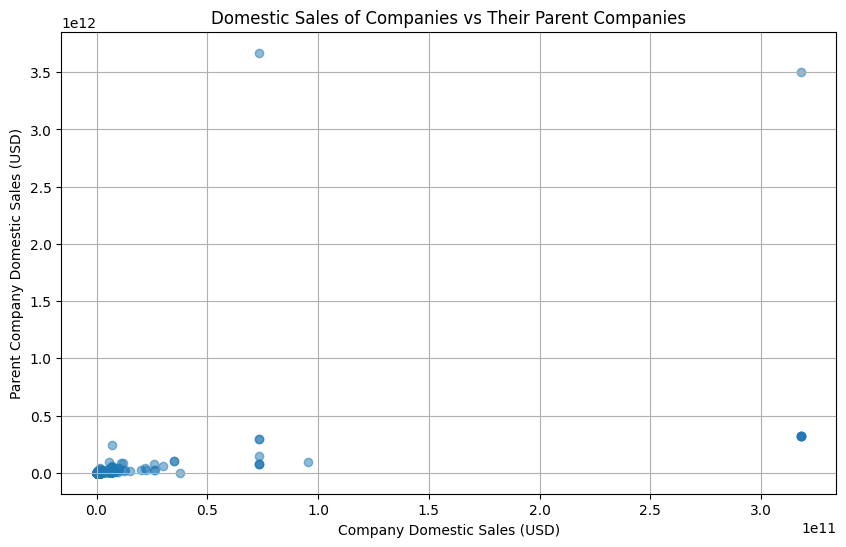

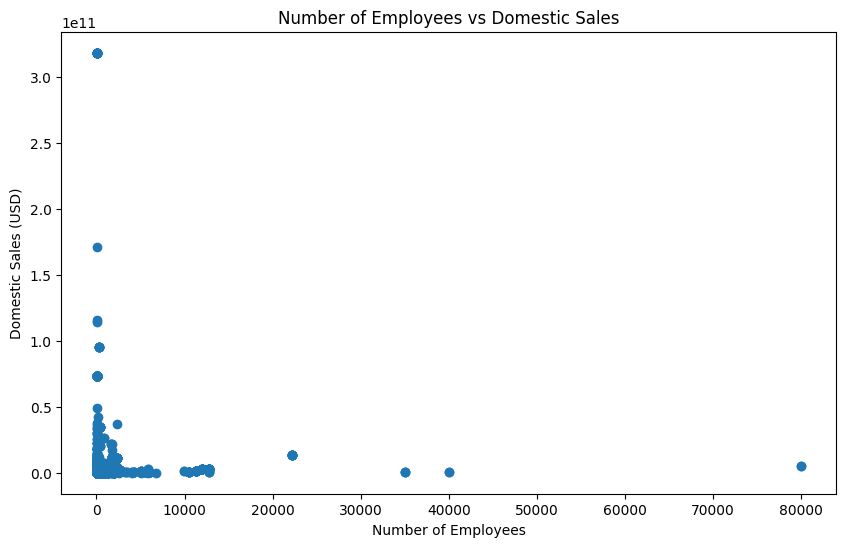

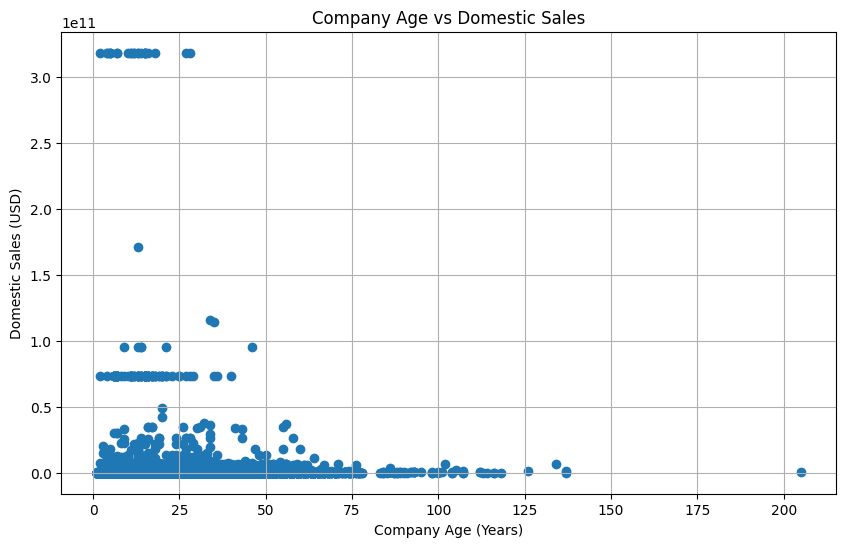

Mean Squared Error: 9.786364542842257e+19
R^2 Score: 0.2900645756054757


In [55]:
#read csv
df = pd.read_csv(filepath)

#delete unimportant columns
del df['Fiscal Year End']
del df['Import/Export Status']
del df['Square Footage']
del df['Employees (Single Site)']
del df['8-Digit SIC Code']
del df['SIC Code']
del df['8-Digit SIC Description']
del df['Company Description']
del df['AccountID']
del df['Global Ultimate Country']
del df['Parent Country']

#dropping na values
df = df[df['Company Status (Active/Inactive)'] == 'Active']
df = df.dropna(subset=["LATITUDE", "LONGITUDE"])
df = df.dropna(subset=['Year Found'])

#make new column company age
currentYear = 2024
df['Company Age'] = currentYear - df['Year Found']

# delete year found column
del df['Year Found']

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Calculate mean only for numeric columns
numeric_means = df[numeric_cols].mean()

# Fill missing values in numeric columns with their means
df[numeric_cols] = df[numeric_cols].fillna(numeric_means)
df[non_numeric_cols] = df[non_numeric_cols].fillna('') 

# data info
df.info()

# Applying one-hot encoding
categorical_columns = ['Industry', 'Entity Type',
                     'Ownership Type', 'Company Status (Active/Inactive)', 
                       'Is Domestic Ultimate', 'Is Global Ultimate']

df = pd.get_dummies(df, columns=categorical_columns)

numerical_df = df.select_dtypes(include=['float64', 'int64'])
# Create a correlation matrix
correlation_matrix = numerical_df.corr()
correlation_df = pd.DataFrame(correlation_matrix)
correlation_df

filtered_df = df[df['Company'] != df['Parent Company']]
filtered_df = filtered_df.dropna(subset=['Parent Company'])
company_sales = filtered_df.groupby('Company')['Sales (Domestic Ultimate Total USD)'].sum()
parent_company_sales = filtered_df.groupby('Parent Company')['Sales (Domestic Ultimate Total USD)'].sum()
merged_sales = pd.merge(left=company_sales, right=parent_company_sales, left_on='Company', right_on='Parent Company', how='inner')
merged_sales.columns = ['Company Sales', 'Parent Company Sales']

#plot parent sales vs company sales
plt.figure(figsize=(10, 6))
plt.scatter(merged_sales['Company Sales'], merged_sales['Parent Company Sales'], alpha=0.5)
plt.title('Domestic Sales of Companies vs Their Parent Companies')
plt.xlabel('Company Domestic Sales (USD)')
plt.ylabel('Parent Company Domestic Sales (USD)')
plt.grid(True)
plt.show()

#plot Number of employees vs sales
plt.figure(figsize=(10,6))
plt.scatter(df['Employees (Domestic Ultimate Total)'], df['Sales (Domestic Ultimate Total USD)'])
plt.title('Number of Employees vs Domestic Sales')
plt.xlabel('Number of Employees')
plt.ylabel('Domestic Sales (USD)')
plt.show()

#plot company age vs sales
plt.figure(figsize=(10, 6))
plt.scatter(df['Company Age'], df['Sales (Domestic Ultimate Total USD)'])
plt.title('Company Age vs Domestic Sales')
plt.xlabel('Company Age (Years)')
plt.ylabel('Domestic Sales (USD)')
plt.grid(True)
plt.show()

#use gradient boosting model
# Selecting features and target variable
X = df.drop(['Sales (Domestic Ultimate Total USD)', 'Company', 'Parent Company', 'Global Ultimate Company', 'Domestic Ultimate Company'], axis=1)
y = df['Sales (Domestic Ultimate Total USD)']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions and mean sq error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

y_pred = model.predict(X_test)
# calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [11]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    ''' Function to test on hidden data and return predictions. '''
    
    # Apply the same preprocessing as done on the training data
    # Dropping columns not used in the model
    columns_to_drop = ['Fiscal Year End', 'Import/Export Status', 'Square Footage', 
                       'Employees (Single Site)', '8-Digit SIC Code', 'SIC Code', 
                       '8-Digit SIC Description', 'Company Description', 'AccountID', 
                       'Global Ultimate Country', 'Parent Country', 'Year Found']
    hidden_data = hidden_data.drop(columns=columns_to_drop, errors='ignore')

    # Calculate Company Age
    currentYear = 2024
    hidden_data['Company Age'] = currentYear - hidden_data['Year Found']

    # Fill missing values
    numeric_cols = hidden_data.select_dtypes(include=[np.number]).columns
    non_numeric_cols = hidden_data.select_dtypes(exclude=[np.number]).columns
    hidden_data[numeric_cols] = hidden_data[numeric_cols].fillna(hidden_data[numeric_cols].mean())
    hidden_data[non_numeric_cols] = hidden_data[non_numeric_cols].fillna('')

    # One-hot encode categorical variables
    categorical_columns = ['Industry', 'Entity Type', 'Ownership Type', 
                           'Company Status (Active/Inactive)', 'Is Domestic Ultimate', 'Is Global Ultimate']
    hidden_data = pd.get_dummies(hidden_data, columns=categorical_columns)

    # Adding missing columns with default value 0
    for col in model.feature_importances_.index: 
        if col not in hidden_data.columns:
            hidden_data[col] = 0

    # Reorder columns to match the training set
    hidden_data = hidden_data[model.feature_importances_.index]

    # Scale the data
    hidden_data_scaled = scaler.transform(hidden_data)  

    # Make predictions
    predictions = model.predict(hidden_data_scaled)

    return predictions.tolist()  


##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!